- Agrega offset de 0.5 y duration reducida a 2.5 respecto a v1 (Resultado: Mejora de accuracy de 5%)
- Agregar 5 bines


## Imports

In [1]:
import os
import sys

# Set parent directory
os.chdir(os.path.dirname(os.getcwd()))

import pandas as pd
import numpy as np

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
#import librosa.display # Aparentemente esto bugea todo segun un git issue 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import keras
from python_speech_features import mfcc
import scipy.io.wavfile as wav
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
# from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

from joblib import dump, load

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Data load

In [2]:
base_url = "C:/Users/Emanuel/Documents/Github/SER/datasets"

# Paths for data.
Ravdess = f"{base_url}/RAVDESS/audio_speech_actors_01-24"

ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + f'/{dir}')
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + f'/{dir}/{file}')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,neutral,C:/Users/Emanuel/Documents/Github/SER/datasets...
1,neutral,C:/Users/Emanuel/Documents/Github/SER/datasets...
2,neutral,C:/Users/Emanuel/Documents/Github/SER/datasets...
3,neutral,C:/Users/Emanuel/Documents/Github/SER/datasets...
4,calm,C:/Users/Emanuel/Documents/Github/SER/datasets...


## Feature Extraction

In [3]:
from src.components.feature_extraction import bin_features

data, sample_rate = librosa.load(Ravdess_df.Path[0], duration = 2.5, offset = 0.5)

asd = bin_features(data, sample_rate, 5)

np.shape(asd)

In [3]:
X, Y = [], []

for path, emotion in zip(Ravdess_df.Path, Ravdess_df.Emotions):
    
    data, sample_rate = librosa.load(path, duration = 2.5, offset = 0.5)
    
    X.append(librosa.feature.mfcc(y = data, sr = sample_rate).T.mean(axis = 0))
    Y.append(emotion)
    
df_features = pd.DataFrame(X)

df_features['labels'] = Y

## Data preparation

In [4]:
X = df_features.iloc[: ,:-1].values
Y = df_features['labels'].values

In [5]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1080, 20), (1080, 8), (360, 20), (360, 8))

In [7]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1080, 20), (1080, 8), (360, 20), (360, 8))

In [8]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1080, 20, 1), (1080, 8), (360, 20, 1), (360, 8))

## Model Training

In [9]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 256)           1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 10, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 5, 256)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 5, 128)            163968    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 3, 128)            0

In [10]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/100
17/17 [==============================] - 1s 22ms/step - loss: 2.0751 - accuracy: 0.1407 - val_loss: 2.0577 - val_accuracy: 0.1361 - lr: 0.0010
Epoch 2/100
17/17 [==============================] - 0s 14ms/step - loss: 2.0500 - accuracy: 0.1667 - val_loss: 2.0242 - val_accuracy: 0.1694 - lr: 0.0010
Epoch 3/100
17/17 [==============================] - 0s 15ms/step - loss: 2.0289 - accuracy: 0.1722 - val_loss: 2.0233 - val_accuracy: 0.2083 - lr: 0.0010
Epoch 4/100
17/17 [==============================] - 0s 14ms/step - loss: 2.0107 - accuracy: 0.1972 - val_loss: 1.9854 - val_accuracy: 0.2111 - lr: 0.0010
Epoch 5/100
17/17 [==============================] - 0s 13ms/step - loss: 1.9809 - accuracy: 0.2148 - val_loss: 1.9652 - val_accuracy: 0.2417 - lr: 0.0010
Epoch 6/100
17/17 [==============================] - 0s 13ms/step - loss: 1.9303 - accuracy: 0.2278 - val_loss: 1.8947 - val_accuracy: 0.2833 - lr: 0.0010
Epoch 7/100
17/17 [==============================] - 0s 14ms/step - lo

## Results

12/12 [==============================] - 0s 2ms/step - loss: 2.1263 - accuracy: 0.6333
Accuracy of our model on test data :  63.333332538604736 %


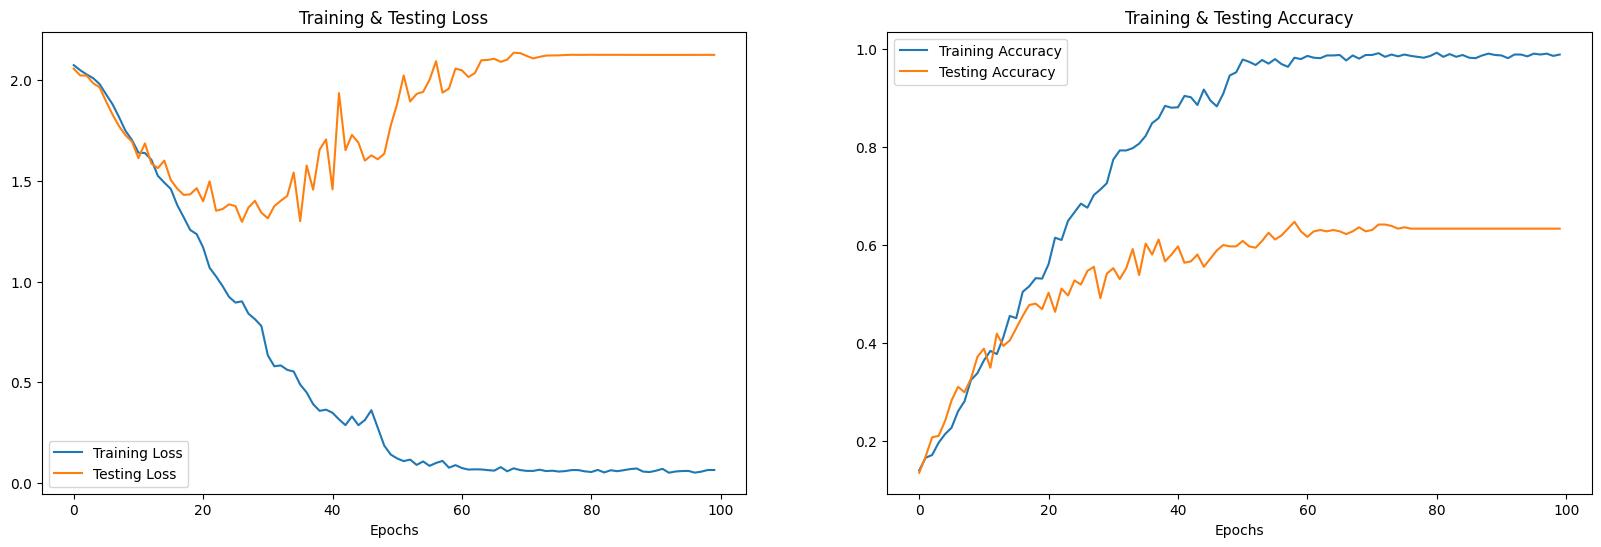

In [11]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [12]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

12/12 [==============================] - 0s 3ms/step


In [13]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,angry,angry
1,fear,fear
2,surprise,surprise
3,angry,angry
4,calm,sad
5,calm,calm
6,sad,calm
7,sad,fear
8,disgust,disgust
9,happy,disgust


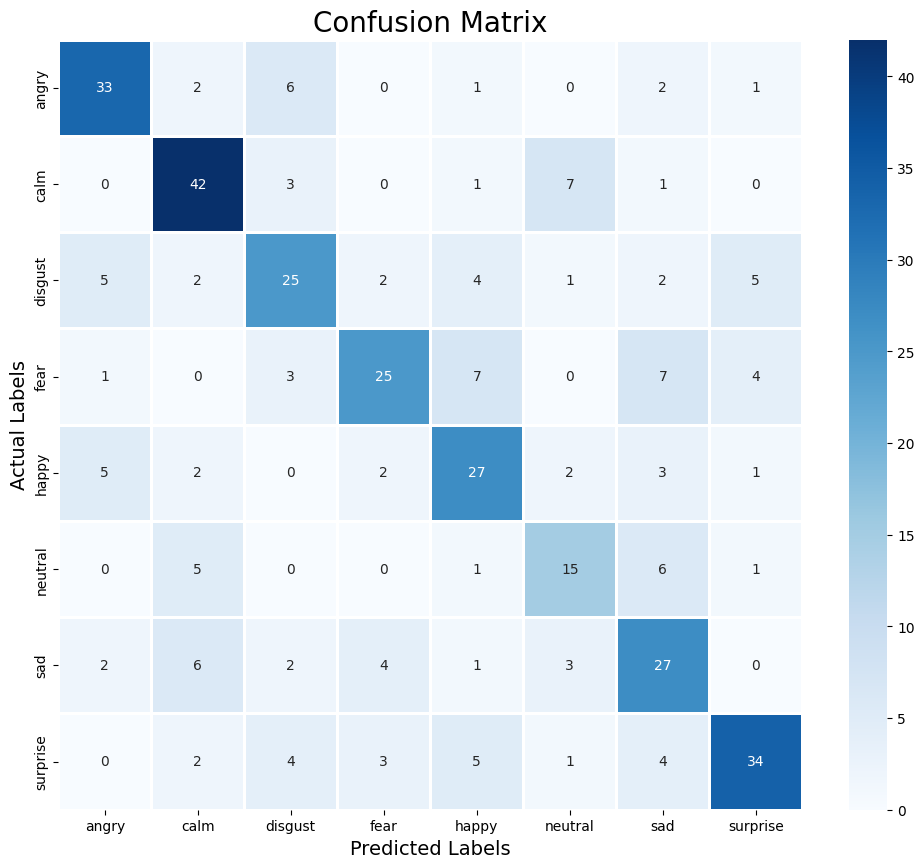

In [14]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.72      0.73      0.73        45
        calm       0.69      0.78      0.73        54
     disgust       0.58      0.54      0.56        46
        fear       0.69      0.53      0.60        47
       happy       0.57      0.64      0.61        42
     neutral       0.52      0.54      0.53        28
         sad       0.52      0.60      0.56        45
    surprise       0.74      0.64      0.69        53

    accuracy                           0.63       360
   macro avg       0.63      0.63      0.62       360
weighted avg       0.64      0.63      0.63       360

